In [1]:
import os, datetime, time, re, warnings, gc, json, random, yaml, pickle

from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import multiprocessing
from multiprocessing import Pool

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, f1_score
from sklearn import datasets, manifold, mixture, model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import MiniBatchKMeans

from scipy.sparse import vstack, csr_matrix, save_npz, load_npz, hstack

from gensim import corpora, models, similarities
from gensim.models import Word2Vec

import lightgbm as lgb
import optuna.integration.lightgbm as tuna

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 256)
pd.set_option("display.max_rows", 256)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    print(f'[{title}] start')
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
class FeatureEngineering(metaclass=ABCMeta):
    BASE_DIR = "."
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_train"
        self.test_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_test"
    
    @abstractmethod
    def load_data(self):
        raise NotImplementedError

    @abstractmethod
    def create_features(self):
        raise NotImplementedError
        
    def run(self, use_columns=[], skip_columns=[]):
        with timer(self.name):
            self.load_data()
            self.replace_na(use_columns=use_columns, skip_columns=skip_columns)
            self.onehot_encode(use_columns=use_columns, skip_columns=skip_columns)
            self.create_features()
        
        return self
    
    def onehot_encode(self, use_columns=[], skip_columns=[], sparse=False):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        self.label_encode(use_columns, skip_columns)
        if sparse:
            encoder = OneHotEncoder(categories='auto', sparse=sparse, dtype='uint8').fit(pd.concat([self.train.loc[:, use_columns], self.test.loc[:, use_columns]]))
            m = 100000
            train = vstack([encoder.transform(self.train[i*m:(i+1)*m].loc[:, use_columns]) for i in range(self.train.shape[0] // m + 1)])
            test  = vstack([encoder.transform(self.test[i*m:(i+1)*m].loc[:, use_columns])  for i in range(self.test.shape[0] // m +  1)])
            save_npz(f"{self.train_file_path}.npz", train, compressed=True)
            save_npz(f"{self.test_file_path}.npz",  test,  compressed=True)
        else:
            self.train["is_train_date"] = 1
            self.test["is_train_date"]  = 0
            df = pd.concat([self.train, self.test])
            del self.train, self.test
            gc.collect()
            for col in use_columns:
                df = df.join(pd.get_dummies(df[col], prefix=col))
            
            self.train = df[df["is_train_date"]==1]
            self.test = df[df["is_train_date"]==0]
            self.train.drop(columns="is_train_date", inplace=True)
            self.test.drop(columns="is_train_date", inplace=True)
            
        return self
    
    def label_encode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        for col in use_columns:
            if df[col].dtype.name in ["object", "category"]:
                df[col] = df[col].astype(str)
                le = LabelEncoder().fit(df[col])
                df[col] = le.transform(df[col])+1
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
    
        return self
    
    def target_encode(self, col_name, target_name, min_samples_leaf=1, smoothing=1, noise_level=0):
        trn_series = self.train[col_name]
        tst_series = self.test[col_name]
        target = self.train[target_name]
        
        assert len(trn_series) == len(target)

        temp = pd.concat([trn_series, target], axis=1)
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
        prior = target.mean()
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_trn_series.index = trn_series.index 
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_tst_series.index = tst_series.index

        self.train[f"te_smoothing_{col_name}"], self.test[f"te_smoothing_{col_name}"] = self.__add_noise(ft_trn_series, noise_level), self.__add_noise(ft_tst_series, noise_level)
        
        return self
    
    def agg_transform(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"

        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
            
        for k, v in agg.items():
            if type(v) is str:
                df[f"{prefix}{k}_{v}"] = df.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    df[f"{prefix}{k}_{vv}"] = df.groupby(group)[k].transform(vv)
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def agg_transform_ratio(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"
        prefix = f"ratio_{prefix}"
        
        for k, v in agg.items():
            if type(v) is str:
                self.train[f"{prefix}{k}_{v}"] = self.train[k] / self.train.groupby(group)[k].transform(v)
                self.test[f"{prefix}{k}_{v}"] = self.test[k] / self.test.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    self.train[f"{prefix}{k}_{vv}"] = self.train[k] / self.train.groupby(group)[k].transform(vv)
                    self.test[f"{prefix}{k}_{vv}"] = self.test[k] / self.test.groupby(group)[k].transform(vv)
        
        return self
    
    def replace_na(self, use_columns=[], skip_columns=[], fill_value=-1):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)

        return self
    
    def replace_na_mode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mode().values[0])
            self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mode().values[0])

        return self
    
    def replace_na_mean(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mean())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mean())

        return self

    def replace_na_median(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].median())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].median())

        return self
    
    def calc_topic_score(self, topic_text_columns, num_topics=5):
        df = pd.concat([self.train.loc[:, topic_text_columns], self.test.loc[:, topic_text_columns]])
        
        for col in topic_text_columns:
            texts = [[word for word in document.lower().split()] for document in df[col].values]
            dictionary = corpora.Dictionary(texts)
            bow_corpus = [dictionary.doc2bow(t) for t in texts]
            lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=num_topics)
                        
            size = df.shape[0]
            topics = {i:[-1]*size for i in range(num_topics)}
            for i, row in enumerate(lda[bow_corpus]):
                for (topic_num, prop_topic) in row:
                    topics[topic_num][i] = prop_topic
            
            for i in range(num_topics):
                self.train[f"{col}_topic_{i}"] = topics[i][:self.train.shape[0]]
                self.test[f"{col}_topic_{i}"] = topics[i][self.train.shape[0]:]

        return self
    
    def calc_scdv_word2vec_score(self, text_col_name):
        features_num = 20
        min_word_count = 10
        context = 5
        downsampling = 1e-3
        epoch_num = 10
        clusters_num = 6
        
        df = pd.concat([self.train.loc[:, [text_col_name]], self.test.loc[:, [text_col_name]]])
        df[text_col_name] = df[text_col_name].fillna("")
        
        corpus = [self.__analyzer_cat(text) for text in df[text_col_name]]
        word2vecs = Word2Vec(sentences=corpus, iter=epoch_num, size=features_num, min_count=min_word_count, window=context, sample=downsampling)
        word_vectors = word2vecs.wv.vectors
        
        gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied', max_iter=50)
        gmm.fit(word_vectors)
        
        tfidf_vectorizer = TfidfVectorizer(analyzer=self.__analyzer_cat, min_df=min_word_count)
        tfidfs = tfidf_vectorizer.fit_transform(df[text_col_name])
        
        idf_dic = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer._tfidf.idf_))
        assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict(word_vectors)))
        soft_assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict_proba(word_vectors)))
        
        word_topic_vecs = {}
        for word in assign_dic:
            word_topic_vecs[word] = np.zeros(features_num*clusters_num, dtype=np.float32)
            for i in range(0, clusters_num):
                try:
                    word_topic_vecs[word][i*features_num:(i+1)*features_num] = word2vecs.wv[word]*soft_assign_dic[word][i]*idf_dic[word]
                except:
                    continue
        
        scdvs = np.zeros((len(df[text_col_name]), clusters_num*features_num), dtype=np.float32)

        a_min = 0
        a_max = 0

        for i, text in enumerate(df[text_col_name]):
            tmp = np.zeros(clusters_num*features_num, dtype=np.float32)
            words = self.__analyzer_cat(text)
            for word in words:
                if word in word_topic_vecs:
                    tmp += word_topic_vecs[word]
            norm = np.sqrt(np.sum(tmp**2))
            if norm > 0:
                tmp /= norm
            a_min += min(tmp)
            a_max += max(tmp)
            scdvs[i] = tmp

        p = 0.04
        a_min = a_min*1.0 / len(df[text_col_name])
        a_max = a_max*1.0 / len(df[text_col_name])
        thres = (abs(a_min)+abs(a_max)) / 2
        thres *= p
        scdvs[abs(scdvs) < thres] = 0
        
        tsne_scdv = manifold.TSNE(n_components=2).fit_transform(scdvs)
        
        self.train[f"scdv_{text_col_name}_x"] = tsne_scdv[:self.train.shape[0], 0]
        self.train[f"scdv_{text_col_name}_y"] = tsne_scdv[:self.train.shape[0], 1]        
        self.test[f"scdv_{text_col_name}_x"] = tsne_scdv[self.train.shape[0]:, 0]
        self.test[f"scdv_{text_col_name}_y"] = tsne_scdv[self.train.shape[0]:, 1]
        
        return self
    
    def yeo_johnson(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        pt = PowerTransformer(method='yeo-johnson')
        pt.fit(df[num_columns])

        df[num_columns] = pt.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def umap_scaler(self, skip_columns=[]):
        self.yeo_johnson(skip_columns=skip_columns)
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]
        for col in num_columns:
            df[col] = df[col].replace(np.inf, np.nan)
            df[col].fillna(-9999, inplace=True)
        
        um = umap.UMAP()
        um.fit(df[num_columns])
        d = um.transform(df[num_columns])
        df["umap_d1"] = d[:, 0]
        df["umap_d2"] = d[:, 1]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def create_kmean_features(self, seed, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        for col in num_columns:
            df[col].fillna(-9999, inplace=True)
        X = df[num_columns]
        
        kmeans = MiniBatchKMeans(n_clusters=10, random_state=seed)
        kmeans.fit(X)

        df["k_class"] = kmeans.predict(X)
        train_distances = kmeans.transform(X)
        for i in range(10):
            df[f"k_distance_{i}"] = train_distances[:, i]
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def min_max_scaling(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        
        scaler = MinMaxScaler()
        scaler.fit(df[num_columns])
        df[num_columns] = scaler.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def two_by_two(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        targets = num_columns.copy()
        for col in num_columns:
            targets.remove(col)
            for t in targets:
                df[f"{col}_{t}_mul"] = df[col] * df[t]
                df[f"{col}_{t}_sub_left"] = df[col] / df[t]
                df[f"{col}_{t}_sub_right"] = df[t] / df[col]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def columns_1d(self):
        self.train.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.train.columns.tolist()])
        self.test.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.test.columns.tolist()])

        return self
    
    def head(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train head: {title}")
        print(self.train.loc[:, train_cols].head(limit))
        print("----------------------------")
        print(f"test head: {title}")
        print(self.test.loc[:, test_cols].head(limit))
        print("----------------------------")
        
        return self
    
    def tail(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train tail: {title}")
        print(self.train.loc[:, train_cols].tail(limit))
        print("----------------------------")
        print(f"test tail: {title}")
        print(self.test.loc[:, test_cols].tail(limit))
        print("----------------------------")
        
        return self
    
    def save(self, format="feather", index=False):
        if format == "feather":
            self.train.to_feather(f"{self.train_file_path}.ftr")
            self.test.to_feather(f"{self.test_file_path}.ftr")
        elif format == "csv":
            self.train.to_csv(f"{self.train_file_path}.csv", index=index)
            self.test.to_csv(f"{self.test_file_path}.csv", index=index)
        
        return self
    
    def __add_noise(self, series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def __analyzer_nlp(self, text):
        stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
        text = text.lower()
        text = text.replace('\n', '')
        text = text.replace('\t', '')
        text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text)
        text = text.split(' ')

        words = []
        for word in text:
            if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None):
                continue
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            words.append(word)

        return words

    def __analyzer_cat(self, text):
        return text.split(' ')

In [4]:
class AutoML():
    SEED = 42
    EVAL_COLUMN = "_preds"
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self, engine):
        if not isinstance(engine, FeatureEngineering): raise TypeError
        self.engine = engine
    
    def run(self, scenario):
        self.__seed_everything(AutoML.SEED)
        self.target = scenario["target"]
        self.engine.load_data()
        
        params = {
            'objective': scenario["objective"],
            'boosting_type': scenario["boosting_type"], 
            'metric': scenario["metric"],
            'n_jobs': -1,
            'seed': AutoML.SEED
        }
        tuned = self.__hyper_parameter_tuning(params)
        params = dict(params, **tuned)
        
        self.predicts, importance = self.__train(params)
        
    def greedy_forward_selection(self, base_score, base_path="./"):
        self.__seed_everything(AutoML.SEED)
        best_score = 0.0
        selected = set([])
        params = None
        scenario = None
        del self.engine.train, self.engine.test
        with open(f"{base_path}/param_{base_score}.json") as f:
            params = json.load(f)
        with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
            scenario = yaml.safe_load(yml)
        self.target = scenario["target"]
        
        train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
        test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")
        
        train_x = [f for f in train.columns if f not in self.target]
        while True:
            if len(selected) == len(train_x): break
            
            scores = []
            for col in train_x:
                if col not in selected:
                    feats = list(selected) + [col]
                    self.engine.train = train[list(feats)+[self.target]]
                    self.engine.test = test[feats]
                    self.predicts, importance = self.__train(params)
                    param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]))
                    scores.append((col, param_with_score["score"]))
            
            b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1], reverse=True)[0]
            print(f"b_score: {b_score}")
            print(f"best_score: {best_score}")
            if b_score > best_score:
                selected.add(b_feature)
                best_score = b_score
                print(f'selected:{b_feature}')
                print(f'score:{b_score}')
            else:
                break
        
        print(f'selected features: {selected}')
        with open("selected.pkl", "wb") as fw:
            pickle.dump(selected, fw)
            
    def __do(self, command):
        if command == "fill_numeric_na":
            self.__fill_numeric_na()
        if command == "binning":
            self.__binning()
        if command == "transformation":
            self.__transformation()
        if command == "topic_encoding":
            self.__topic_encoding()
        if command == "umap":
            self.engine.umap_scaler(skip_columns=[self.target])
        if command == "kmean_features":
            self.engine.create_kmean_features(skip_columns=[self.target], seed=AutoML.SEED)
        if command == "min_max_scaling":
            self.engine.min_max_scaling(skip_columns=[self.target])
        if command == "two_by_two":
            self.engine.two_by_two(skip_columns=[self.target])
    
    def __evaluate(self, params, actuals, metric):
        calc_score_param = {"metric": metric}
        actuals[AutoML.EVAL_COLUMN] = self.predicts
        if params["objective"] == "binary":
            actuals.loc[actuals[AutoML.EVAL_COLUMN]>=0.5, AutoML.EVAL_COLUMN] = 1
            actuals.loc[actuals[AutoML.EVAL_COLUMN]<0.5, AutoML.EVAL_COLUMN] = 0
            actuals[AutoML.EVAL_COLUMN] = actuals[AutoML.EVAL_COLUMN].astype("int")
        
        score = self.__calc_score(calc_score_param, actuals[self.target], actuals[AutoML.EVAL_COLUMN])
        params["score"] = score
        print(f"Score: {score}")
        return params
    
    def __transformation(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        aggs = ["min", "max", "mean", "std"]
        for col in feats:
            if self.engine.train[col].dtype.name == "category":
                self.engine.agg_transform(group=[col], agg={f"{col}": ["count"]})
            for c in num_columns:
                if c == col: continue
                self.engine.agg_transform(group=[col], agg={f"{c}": aggs})
                for agg in aggs:
                    if self.engine.train[self.engine.train[f"{col}_{c}_{agg}"].isnull()].shape[0] > 0:
                        self.engine.train.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)
                        self.engine.test.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)

    def __fill_numeric_na(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        cat_columns = [col for col in feats if self.engine.train[col].dtype.name == "category"]
        groups = []
        for c in cat_columns:
            if self.engine.train[self.engine.train[c].isnull()].shape[0] == 0:
                if self.engine.train.groupby(c).size().shape[0] / self.engine.train.shape[0] < 0.1:
                    groups.append(c)
        for n in num_columns:
            if len(groups) > 0:
                self.engine.agg_transform(group=groups, agg={f"{n}": ["mean"]}, prefix="_tmp")
                self.engine.train[n].fillna(self.engine.train[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test[n].fillna(self.engine.test[f"_tmp_{n}_mean"], inplace=True)
                self.engine.train.drop(columns=[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test.drop(columns=[f"_tmp_{n}_mean"], inplace=True)

    def __binning(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()

        for c in num_columns:
            if df[c].unique().shape[0] > 100:
                df[f"{c}_bin"] = pd.cut(df[c], 10, labels=False)
        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __topic_encoding(self):
        self.__create_topic_text()
        self.engine.calc_topic_score(topic_text_columns=["topic_text"], num_topics=5)
        self.__drop_features(["topic_text"])

    def __create_topic_text(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()
        
        df["topic_text"] = ""
        for c in num_columns:
            df["topic_text"] = df["topic_text"].astype(str) + " " + df[c].astype(str)

        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __set_column_type(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        for col in feats:
            col_type = self.engine.train[col].dtypes
            if self.engine.train[col].unique().shape[0] < 20:
                self.engine.train[col] = self.engine.train[col].astype("category")
                self.engine.test[col] = self.engine.test[col].astype("category")

    def __drop_features(self, cols):
        feats = [f for f in self.engine.train.columns if f in cols]
        self.engine.train.drop(columns=feats, inplace=True)
        self.engine.test.drop(columns=feats, inplace=True)
    
    def __feature_selection(self, cols):
        self.engine.train = self.engine.train.loc[:, list(cols)+[self.target]]
        self.engine.test = self.engine.test.loc[:, cols]
    
    def __hyper_parameter_tuning(self, params):
        train, valid = model_selection.train_test_split(self.engine.train, test_size=0.33, random_state=AutoML.SEED, shuffle=True)
        feats = list(range(0, 38))
        
        lgb_train = tuna.Dataset(train[feats], label=train[self.target].values)
        lgb_valid = tuna.Dataset(valid[feats], label=valid[self.target].values)
        best_params, tuning_history = dict(), list()

        model = tuna.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        best_params=best_params,
                        tuning_history=tuning_history
                        )

        return best_params
    
    def __adversarial_validation(self, num_folds=5):
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        feats = [f for f in self.engine.train.columns if f not in self.target]
        train = self.engine.train[feats]
        test = self.engine.test[feats]
        train[self.target] = 0
        test[self.target] = 1
        
        df = pd.concat([train, test], ignore_index=True)
        del train, test
        gc.collect()
        
        oof_preds = np.zeros(df.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[self.target])):
            train_x, train_y = df[feats].iloc[train_idx], df[self.target].iloc[train_idx]
            valid_x, valid_y = df[feats].iloc[valid_idx], df[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            params = {'num_leaves': 50,
                     'min_data_in_leaf': 30, 
                     'objective':'binary',
                     'max_depth': 5,
                     'learning_rate': 0.1,
                     "min_child_samples": 20,
                     "boosting": "gbdt",
                     "feature_fraction": 0.9,
                     "bagging_freq": 1,
                     "bagging_fraction": 0.9 ,
                     "bagging_seed": 44,
                     "metric": 'auc',
                     "verbosity": -1}

            model = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100
                        )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        self.__display_importances(feature_importance_df)
        
        return sum(scores)/len(scores), feature_importance_df
        
    def __train(self, params, num_folds=5, stratified=False):
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)

        feats = list(range(0, 38))
        oof_preds = np.zeros(self.engine.train.shape[0])
        sub_preds = np.zeros(self.engine.test.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(self.engine.train[feats], self.engine.train[self.target])):
            train_x, train_y = self.engine.train[feats].iloc[train_idx], self.engine.train[self.target].iloc[train_idx]
            valid_x, valid_y = self.engine.train[feats].iloc[valid_idx], self.engine.train[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            model = lgb.train(
                            params,
                            lgb_train,
                            valid_sets=[lgb_train, lgb_valid],
                            valid_names=['train', 'valid'],
                            num_boost_round=1000, 
                            early_stopping_rounds=100,
                            verbose_eval=100
                            )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
            sub_preds += model.predict(self.engine.test[feats], num_iteration=model.best_iteration) / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        print('CV : %.6f' % (sum(scores)/len(scores)))
        self.__display_importances(feature_importance_df)

        return sub_preds, feature_importance_df
    
    def __display_importances(self, feature_importance_df_):
        all_cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
        feature_importance_df_.loc[feature_importance_df_.feature.isin(all_cols)].to_csv("feature_importance.csv", index=False)

        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

        plt.figure(figsize=(8, 10))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')
    
    def __calc_score(self, params, actuals, preds):
        if params["metric"] == "rmse":
            return np.sqrt(mean_squared_error(actuals, preds))
        if params["metric"] in ["cross_entropy", "binary_logloss"]:
            return log_loss(actuals, preds)
        if params["metric"] == "auc":
            return roc_auc_score(actuals, preds)
        if params["metric"] == "f1":
            return f1_score(actuals, preds)

    def __seed_everything(self, seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)

In [5]:
class Sample(FeatureEngineering):
    def load_data(self):
        self.train = pd.read_pickle("./structure_train_01.pkl")
        self.test = pd.read_pickle("./structure_train_01.pkl")
        
        self.train.columns = range(0, 38)
        self.test.columns = range(0, 38)
        df = pd.read_pickle("./structure_df_01.pkl")
        self.train["k_class"] = df["k_class"]
        
        return self
    
    def create_features(self):
        return self
    
    def create_topic_text(self):
        return self

In [6]:
with open("../input/building_structure/scenario.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

In [7]:
ml = AutoML(engine=Sample())

tune_feature_fraction, val_score: inf:   0%|                                                     | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.840828	valid's rmse: 1.43749
[200]	train's rmse: 0.643549	valid's rmse: 1.3875
[300]	train's rmse: 0.541128	valid's rmse: 1.36481
[400]	train's rmse: 0.469407	valid's rmse: 1.34843
[500]	train's rmse: 0.415724	valid's rmse: 1.34937
Early stopping, best iteration is:
[468]	train's rmse: 0.431727	valid's rmse: 1.34311


tune_feature_fraction, val_score: 1.343111:  14%|#####7                                  | 1/7 [00:01<00:08,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.78625	valid's rmse: 1.38709
[200]	train's rmse: 0.584155	valid's rmse: 1.34524
[300]	train's rmse: 0.479024	valid's rmse: 1.32631
[400]	train's rmse: 0.416154	valid's rmse: 1.32233
[500]	train's rmse: 0.370263	valid's rmse: 1.32223
Early stopping, best iteration is:
[483]	train's rmse: 0.377563	valid's rmse: 1.31891


tune_feature_fraction, val_score: 1.318905:  29%|###########4                            | 2/7 [00:02<00:05,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.744827	valid's rmse: 1.34727
[200]	train's rmse: 0.54219	valid's rmse: 1.30212
[300]	train's rmse: 0.438215	valid's rmse: 1.29107
[400]	train's rmse: 0.37924	valid's rmse: 1.2868
[500]	train's rmse: 0.336097	valid's rmse: 1.29018
Early stopping, best iteration is:
[443]	train's rmse: 0.358718	valid's rmse: 1.28487


tune_feature_fraction, val_score: 1.284872:  43%|#################1                      | 3/7 [00:02<00:04,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_feature_fraction, val_score: 1.281388:  57%|######################8                 | 4/7 [00:03<00:03,  1.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.69527	valid's rmse: 1.4052
[200]	train's rmse: 0.501272	valid's rmse: 1.34085
[300]	train's rmse: 0.397727	valid's rmse: 1.30075
[400]	train's rmse: 0.33748	valid's rmse: 1.29081
[500]	train's rmse: 0.299897	valid's rmse: 1.28889
[600]	train's rmse: 0.275037	valid's rmse: 1.28817
[700]	train's rmse: 0.257388	valid's rmse: 1.28839
Early stopping, best iteration is:
[663]	train's rmse: 0.263593	valid's rmse: 1.28716


tune_feature_fraction, val_score: 1.281388:  71%|############################5           | 5/7 [00:04<00:01,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.671021	valid's rmse: 1.36212
[200]	train's rmse: 0.476094	valid's rmse: 1.31703
[300]	train's rmse: 0.376739	valid's rmse: 1.2892
[400]	train's rmse: 0.319017	valid's rmse: 1.28408
Early stopping, best iteration is:
[375]	train's rmse: 0.330303	valid's rmse: 1.28193


tune_feature_fraction, val_score: 1.281388:  86%|##################################2     | 6/7 [00:05<00:00,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.67137	valid's rmse: 1.32282
[200]	train's rmse: 0.477038	valid's rmse: 1.30453
[300]	train's rmse: 0.377769	valid's rmse: 1.29169
[400]	train's rmse: 0.320991	valid's rmse: 1.29364
Early stopping, best iteration is:
[328]	train's rmse: 0.358083	valid's rmse: 1.28973


tune_num_leaves, val_score: 1.281388:   0%|                                                     | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.716005	valid's rmse: 1.35427
[200]	train's rmse: 0.50968	valid's rmse: 1.31361
[300]	train's rmse: 0.40913	valid's rmse: 1.29267
[400]	train's rmse: 0.34942	valid's rmse: 1.27951
[500]	train's rmse: 0.308682	valid's rmse: 1.27782
Early stopping, best iteration is:
[467]	train's rmse: 0.319666	valid's rmse: 1.27569


tune_num_leaves, val_score: 1.275692:   5%|##2                                          | 1/20 [00:00<00:08,  2.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  10%|####5                                        | 2/20 [00:01<00:09,  1.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  15%|######7                                      | 3/20 [00:02<00:10,  1.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  20%|#########                                    | 4/20 [00:02<00:10,  1.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  25%|###########2                                 | 5/20 [00:03<00:10,  1.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  30%|#############5                               | 6/20 [00:04<00:09,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  35%|###############7                             | 7/20 [00:05<00:09,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  40%|##################                           | 8/20 [00:05<00:08,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  45%|####################2                        | 9/20 [00:06<00:07,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.275692:  50%|######################                      | 10/20 [00:07<00:07,  1.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.743301	valid's rmse: 1.35698
[200]	train's rmse: 0.549071	valid's rmse: 1.29502
[300]	train's rmse: 0.449645	valid's rmse: 1.27246
[400]	train's rmse: 0.387051	valid's rmse: 1.26075
[500]	train's rmse: 0.343601	valid's rmse: 1.26014
[600]	train's rmse: 0.311697	valid's rmse: 1.25852
[700]	train's rmse: 0.290538	valid's rmse: 1.25663
[800]	train's rmse: 0.27406	valid's rmse: 1.25957
Early stopping, best iteration is:
[726]	train's rmse: 0.285409	valid's rmse: 1.25581


tune_num_leaves, val_score: 1.255809:  55%|########################2                   | 11/20 [00:07<00:06,  1.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.840797	valid's rmse: 1.38042
[200]	train's rmse: 0.673714	valid's rmse: 1.30161
[300]	train's rmse: 0.581168	valid's rmse: 1.26186
[400]	train's rmse: 0.517346	valid's rmse: 1.23911
[500]	train's rmse: 0.469444	valid's rmse: 1.21622
[600]	train's rmse: 0.432806	valid's rmse: 1.21254
[700]	train's rmse: 0.405069	valid's rmse: 1.20629
Early stopping, best iteration is:
[652]	train's rmse: 0.417556	valid's rmse: 1.20355


tune_num_leaves, val_score: 1.203549:  60%|##########################4                 | 12/20 [00:08<00:04,  1.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.14661	valid's rmse: 1.55149
[200]	train's rmse: 0.993384	valid's rmse: 1.43999
[300]	train's rmse: 0.906413	valid's rmse: 1.37382
[400]	train's rmse: 0.852016	valid's rmse: 1.34808
[500]	train's rmse: 0.806986	valid's rmse: 1.32101
[600]	train's rmse: 0.768989	valid's rmse: 1.29825
[700]	train's rmse: 0.731337	valid's rmse: 1.28027
[800]	train's rmse: 0.697774	valid's rmse: 1.2591
[900]	train's rmse: 0.673914	valid's rmse: 1.25293
[1000]	train's rmse: 0.652759	valid's rmse: 1.24478
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.652759	valid's rmse: 1.24478


tune_num_leaves, val_score: 1.203549:  65%|############################6               | 13/20 [00:08<00:04,  1.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.203549:  70%|##############################8             | 14/20 [00:09<00:03,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.35804	valid's rmse: 1.701
[200]	train's rmse: 1.20393	valid's rmse: 1.61125
[300]	train's rmse: 1.12536	valid's rmse: 1.57784
[400]	train's rmse: 1.07643	valid's rmse: 1.55016
[500]	train's rmse: 1.01954	valid's rmse: 1.48857
[600]	train's rmse: 0.989921	valid's rmse: 1.47292
[700]	train's rmse: 0.966137	valid's rmse: 1.46389
[800]	train's rmse: 0.938619	valid's rmse: 1.45093
[900]	train's rmse: 0.919288	valid's rmse: 1.44342
[1000]	train's rmse: 0.89793	valid's rmse: 1.42051
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.89793	valid's rmse: 1.42051


tune_num_leaves, val_score: 1.203549:  75%|#################################           | 15/20 [00:09<00:02,  1.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.203549:  80%|###################################2        | 16/20 [00:10<00:02,  1.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.203549:  85%|#####################################4      | 17/20 [00:11<00:01,  1.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.203549:  90%|#######################################6    | 18/20 [00:12<00:01,  1.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.203549:  95%|#########################################8  | 19/20 [00:12<00:00,  1.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.203549: 100%|############################################| 20/20 [00:13<00:00,  1.49it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:   0%|                              | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.284	valid's rmse: 1.77255
[200]	train's rmse: 1.11501	valid's rmse: 1.67302
[300]	train's rmse: 1.01702	valid's rmse: 1.60425
[400]	train's rmse: 0.947354	valid's rmse: 1.54715
[500]	train's rmse: 0.886389	valid's rmse: 1.52922
[600]	train's rmse: 0.837757	valid's rmse: 1.52585
Early stopping, best iteration is:
[561]	train's rmse: 0.856532	valid's rmse: 1.50632


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  10%|##2                   | 1/10 [00:00<00:03,  2.90it/s][I 2020-03-24 17:45:05,532] Finished trial#0 resulted in value: 1.5063225646563334. Current best value is 1.5063225646563334 with parameters: {'bagging_fraction': 0.40313006569359505, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  10%|##2                   | 1/10 [00:00<00:03,  2.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01459	valid's rmse: 1.5354
[200]	train's rmse: 0.837156	valid's rmse: 1.43885
[300]	train's rmse: 0.725609	valid's rmse: 1.41149
[400]	train's rmse: 0.643725	valid's rmse: 1.39322
[500]	train's rmse: 0.581111	valid's rmse: 1.37941
[600]	train's rmse: 0.535991	valid's rmse: 1.36484
[700]	train's rmse: 0.500424	valid's rmse: 1.37098
Early stopping, best iteration is:
[678]	train's rmse: 0.508715	valid's rmse: 1.35641


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  20%|####4                 | 2/10 [00:00<00:03,  2.59it/s][I 2020-03-24 17:45:06,010] Finished trial#1 resulted in value: 1.3564076870707535. Current best value is 1.3564076870707535 with parameters: {'bagging_fraction': 0.6461649259654129, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  20%|####4                 | 2/10 [00:00<00:03,  2.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.928981	valid's rmse: 1.48239
[200]	train's rmse: 0.74554	valid's rmse: 1.41199
[300]	train's rmse: 0.638579	valid's rmse: 1.36542
[400]	train's rmse: 0.568455	valid's rmse: 1.34618
[500]	train's rmse: 0.510457	valid's rmse: 1.32701
[600]	train's rmse: 0.467876	valid's rmse: 1.31964
[700]	train's rmse: 0.434745	valid's rmse: 1.31226
[800]	train's rmse: 0.40641	valid's rmse: 1.3066
[900]	train's rmse: 0.383029	valid's rmse: 1.30324
[1000]	train's rmse: 0.361538	valid's rmse: 1.30131
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.361538	valid's rmse: 1.30131


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  30%|######6               | 3/10 [00:01<00:03,  2.19it/s][I 2020-03-24 17:45:06,633] Finished trial#2 resulted in value: 1.3013117748539187. Current best value is 1.3013117748539187 with parameters: {'bagging_fraction': 0.7854653543499936, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  30%|######6               | 3/10 [00:01<00:03,  2.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.856758	valid's rmse: 1.39372
[200]	train's rmse: 0.691151	valid's rmse: 1.31653
[300]	train's rmse: 0.595372	valid's rmse: 1.27105
[400]	train's rmse: 0.528724	valid's rmse: 1.26703
[500]	train's rmse: 0.477714	valid's rmse: 1.25241
[600]	train's rmse: 0.438905	valid's rmse: 1.2597
Early stopping, best iteration is:
[520]	train's rmse: 0.469628	valid's rmse: 1.25168


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  40%|########8             | 4/10 [00:01<00:02,  2.26it/s][I 2020-03-24 17:45:07,046] Finished trial#3 resulted in value: 1.2516763673326812. Current best value is 1.2516763673326812 with parameters: {'bagging_fraction': 0.9148070302478164, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  40%|########8             | 4/10 [00:01<00:02,  2.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.931043	valid's rmse: 1.5021
[200]	train's rmse: 0.757084	valid's rmse: 1.40808
[300]	train's rmse: 0.647741	valid's rmse: 1.35982
[400]	train's rmse: 0.576836	valid's rmse: 1.33363
[500]	train's rmse: 0.518874	valid's rmse: 1.3153
[600]	train's rmse: 0.476943	valid's rmse: 1.31876
Early stopping, best iteration is:
[513]	train's rmse: 0.513321	valid's rmse: 1.31215


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  50%|###########           | 5/10 [00:02<00:02,  2.28it/s][I 2020-03-24 17:45:07,477] Finished trial#4 resulted in value: 1.312145658602212. Current best value is 1.2516763673326812 with parameters: {'bagging_fraction': 0.9148070302478164, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  50%|###########           | 5/10 [00:02<00:02,  2.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.21625	valid's rmse: 1.67629
[200]	train's rmse: 1.01607	valid's rmse: 1.61026
[300]	train's rmse: 0.905417	valid's rmse: 1.54377
[400]	train's rmse: 0.831662	valid's rmse: 1.52056
[500]	train's rmse: 0.770693	valid's rmse: 1.50198
[600]	train's rmse: 0.720256	valid's rmse: 1.47313
[700]	train's rmse: 0.677985	valid's rmse: 1.45105
Early stopping, best iteration is:
[664]	train's rmse: 0.691619	valid's rmse: 1.43978


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  60%|#############2        | 6/10 [00:02<00:01,  2.20it/s][I 2020-03-24 17:45:07,966] Finished trial#5 resulted in value: 1.4397802390513037. Current best value is 1.2516763673326812 with parameters: {'bagging_fraction': 0.9148070302478164, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  60%|#############2        | 6/10 [00:02<00:01,  2.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.960408	valid's rmse: 1.51241
[200]	train's rmse: 0.785963	valid's rmse: 1.43954
[300]	train's rmse: 0.67992	valid's rmse: 1.37789
[400]	train's rmse: 0.599727	valid's rmse: 1.37435
[500]	train's rmse: 0.544772	valid's rmse: 1.35187
Early stopping, best iteration is:
[492]	train's rmse: 0.550428	valid's rmse: 1.34429


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  70%|###############4      | 7/10 [00:03<00:01,  2.24it/s][I 2020-03-24 17:45:08,396] Finished trial#6 resulted in value: 1.3442873420682697. Current best value is 1.2516763673326812 with parameters: {'bagging_fraction': 0.9148070302478164, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  70%|###############4      | 7/10 [00:03<00:01,  2.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.09315	valid's rmse: 1.60626
[200]	train's rmse: 0.914639	valid's rmse: 1.52806
[300]	train's rmse: 0.811081	valid's rmse: 1.4756
[400]	train's rmse: 0.730153	valid's rmse: 1.45924
[500]	train's rmse: 0.669765	valid's rmse: 1.43097
[600]	train's rmse: 0.622222	valid's rmse: 1.41951
[700]	train's rmse: 0.562753	valid's rmse: 1.3802
[800]	train's rmse: 0.523886	valid's rmse: 1.35669
Early stopping, best iteration is:
[752]	train's rmse: 0.540566	valid's rmse: 1.35402


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  80%|#################6    | 8/10 [00:03<00:00,  2.07it/s][I 2020-03-24 17:45:08,967] Finished trial#7 resulted in value: 1.3540212223064676. Current best value is 1.2516763673326812 with parameters: {'bagging_fraction': 0.9148070302478164, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  80%|#################6    | 8/10 [00:03<00:00,  2.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.966445	valid's rmse: 1.52654
[200]	train's rmse: 0.786348	valid's rmse: 1.44801
[300]	train's rmse: 0.680203	valid's rmse: 1.40149
[400]	train's rmse: 0.59985	valid's rmse: 1.37149
[500]	train's rmse: 0.537339	valid's rmse: 1.36584
Early stopping, best iteration is:
[450]	train's rmse: 0.569459	valid's rmse: 1.35025


tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  90%|###################8  | 9/10 [00:04<00:00,  2.23it/s][I 2020-03-24 17:45:09,338] Finished trial#8 resulted in value: 1.3502522869703668. Current best value is 1.2516763673326812 with parameters: {'bagging_fraction': 0.9148070302478164, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.203549:  90%|###################8  | 9/10 [00:04<00:00,  2.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.849647	valid's rmse: 1.37657
[200]	train's rmse: 0.681753	valid's rmse: 1.29641
[300]	train's rmse: 0.585891	valid's rmse: 1.25224
[400]	train's rmse: 0.516505	valid's rmse: 1.23677
[500]	train's rmse: 0.468345	valid's rmse: 1.21752
[600]	train's rmse: 0.431188	valid's rmse: 1.20869
[700]	train's rmse: 0.402791	valid's rmse: 1.20223
[800]	train's rmse: 0.379001	valid's rmse: 1.19917
[900]	train's rmse: 0.360341	valid's rmse: 1.19743
[1000]	train's rmse: 0.342139	valid's rmse: 1.19552
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.342139	valid's rmse: 1.19552


tune_bagging_fraction_and_bagging_freq, val_score: 1.195520: 100%|#####################| 10/10 [00:04<00:00,  1.99it/s][I 2020-03-24 17:45:09,963] Finished trial#9 resulted in value: 1.1955199892786579. Current best value is 1.1955199892786579 with parameters: {'bagging_fraction': 0.995986656805842, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.195520: 100%|#####################| 10/10 [00:04<00:00,  2.05it/s]
tune_feature_fraction, val_score: 1.195520:   0%|                                                | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.854025	valid's rmse: 1.38168
[200]	train's rmse: 0.691556	valid's rmse: 1.31032
[300]	train's rmse: 0.597655	valid's rmse: 1.29467
[400]	train's rmse: 0.535507	valid's rmse: 1.26901
[500]	train's rmse: 0.489273	valid's rmse: 1.26079
[600]	train's rmse: 0.446882	valid's rmse: 1.24074
[700]	train's rmse: 0.416908	valid's rmse: 1.23298
[800]	train's rmse: 0.393293	valid's rmse: 1.23259
[900]	train's rmse: 0.370748	valid's rmse: 1.22707
[1000]	train's rmse: 0.352724	valid's rmse: 1.22546
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.352724	valid's rmse: 1.22546


tune_feature_fraction, val_score: 1.195520:  17%|######6                                 | 1/6 [00:00<00:02,  1.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.854025	valid's rmse: 1.38168
[200]	train's rmse: 0.691556	valid's rmse: 1.31032
[300]	train's rmse: 0.597655	valid's rmse: 1.29467
[400]	train's rmse: 0.535507	valid's rmse: 1.26901
[500]	train's rmse: 0.489273	valid's rmse: 1.26079
[600]	train's rmse: 0.446882	valid's rmse: 1.24074
[700]	train's rmse: 0.416908	valid's rmse: 1.23298
[800]	train's rmse: 0.393293	valid's rmse: 1.23259
[900]	train's rmse: 0.370748	valid's rmse: 1.22707
[1000]	train's rmse: 0.352724	valid's rmse: 1.22546
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.352724	valid's rmse: 1.22546


tune_feature_fraction, val_score: 1.195520:  33%|#############3                          | 2/6 [00:01<00:02,  1.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.849647	valid's rmse: 1.37657
[200]	train's rmse: 0.681753	valid's rmse: 1.29641
[300]	train's rmse: 0.585891	valid's rmse: 1.25224
[400]	train's rmse: 0.516505	valid's rmse: 1.23677
[500]	train's rmse: 0.468345	valid's rmse: 1.21752
[600]	train's rmse: 0.431188	valid's rmse: 1.20869
[700]	train's rmse: 0.402791	valid's rmse: 1.20223
[800]	train's rmse: 0.379001	valid's rmse: 1.19917
[900]	train's rmse: 0.360341	valid's rmse: 1.19743
[1000]	train's rmse: 0.342139	valid's rmse: 1.19552
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.342139	valid's rmse: 1.19552


tune_feature_fraction, val_score: 1.195520:  50%|####################                    | 3/6 [00:01<00:01,  1.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.849647	valid's rmse: 1.37657
[200]	train's rmse: 0.681753	valid's rmse: 1.29641
[300]	train's rmse: 0.585891	valid's rmse: 1.25224
[400]	train's rmse: 0.516505	valid's rmse: 1.23677
[500]	train's rmse: 0.468345	valid's rmse: 1.21752
[600]	train's rmse: 0.431188	valid's rmse: 1.20869
[700]	train's rmse: 0.402791	valid's rmse: 1.20223
[800]	train's rmse: 0.379001	valid's rmse: 1.19917
[900]	train's rmse: 0.360341	valid's rmse: 1.19743
[1000]	train's rmse: 0.342139	valid's rmse: 1.19552
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.342139	valid's rmse: 1.19552


tune_feature_fraction, val_score: 1.195520:  67%|##########################6             | 4/6 [00:02<00:01,  1.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.849647	valid's rmse: 1.37657
[200]	train's rmse: 0.681753	valid's rmse: 1.29641
[300]	train's rmse: 0.585891	valid's rmse: 1.25224
[400]	train's rmse: 0.516505	valid's rmse: 1.23677
[500]	train's rmse: 0.468345	valid's rmse: 1.21752
[600]	train's rmse: 0.431188	valid's rmse: 1.20869
[700]	train's rmse: 0.402791	valid's rmse: 1.20223
[800]	train's rmse: 0.379001	valid's rmse: 1.19917
[900]	train's rmse: 0.360341	valid's rmse: 1.19743
[1000]	train's rmse: 0.342139	valid's rmse: 1.19552
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.342139	valid's rmse: 1.19552


tune_feature_fraction, val_score: 1.195520:  83%|#################################3      | 5/6 [00:03<00:00,  1.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.829268	valid's rmse: 1.38433
[200]	train's rmse: 0.662039	valid's rmse: 1.29292
[300]	train's rmse: 0.56831	valid's rmse: 1.23597
[400]	train's rmse: 0.510124	valid's rmse: 1.22225
[500]	train's rmse: 0.464026	valid's rmse: 1.21646
[600]	train's rmse: 0.427064	valid's rmse: 1.20704
[700]	train's rmse: 0.400635	valid's rmse: 1.20228
[800]	train's rmse: 0.376027	valid's rmse: 1.19986
[900]	train's rmse: 0.355673	valid's rmse: 1.19568
Early stopping, best iteration is:
[837]	train's rmse: 0.368142	valid's rmse: 1.19472


tune_feature_fraction, val_score: 1.194721: 100%|########################################| 6/6 [00:03<00:00,  1.64it/s]
tune_lambda_l1_and_lambda_l2, val_score: 1.194721:   0%|                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.829268	valid's rmse: 1.38433
[200]	train's rmse: 0.662039	valid's rmse: 1.29292
[300]	train's rmse: 0.56831	valid's rmse: 1.23597
[400]	train's rmse: 0.510124	valid's rmse: 1.22225
[500]	train's rmse: 0.464026	valid's rmse: 1.21646
[600]	train's rmse: 0.427064	valid's rmse: 1.20704
[700]	train's rmse: 0.400635	valid's rmse: 1.20228
[800]	train's rmse: 0.376027	valid's rmse: 1.19986
[900]	train's rmse: 0.355673	valid's rmse: 1.19568
Early stopping, best iteration is:
[837]	train's rmse: 0.368142	valid's rmse: 1.19472


tune_lambda_l1_and_lambda_l2, val_score: 1.194721:   5%|#6                              | 1/20 [00:00<00:09,  1.99it/s][I 2020-03-24 17:45:14,253] Finished trial#0 resulted in value: 1.1947213725372787. Current best value is 1.1947213725372787 with parameters: {'lambda_l1': 8.591307185096571e-07, 'lambda_l2': 1.3304789500580013e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 1.194721:   5%|#6                              | 1/20 [00:00<00:09,  1.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.886741	valid's rmse: 1.41052
[200]	train's rmse: 0.721556	valid's rmse: 1.32149
[300]	train's rmse: 0.618871	valid's rmse: 1.28164
[400]	train's rmse: 0.553559	valid's rmse: 1.25216
[500]	train's rmse: 0.502585	valid's rmse: 1.23468
[600]	train's rmse: 0.463133	valid's rmse: 1.22864
[700]	train's rmse: 0.433261	valid's rmse: 1.22343
Early stopping, best iteration is:
[660]	train's rmse: 0.444673	valid's rmse: 1.2219


tune_lambda_l1_and_lambda_l2, val_score: 1.194721:  10%|###2                            | 2/20 [00:01<00:09,  1.95it/s][I 2020-03-24 17:45:14,791] Finished trial#1 resulted in value: 1.2219038468787151. Current best value is 1.1947213725372787 with parameters: {'lambda_l1': 8.591307185096571e-07, 'lambda_l2': 1.3304789500580013e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 1.194721:  10%|###2                            | 2/20 [00:01<00:09,  1.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.844747	valid's rmse: 1.38662
[200]	train's rmse: 0.672747	valid's rmse: 1.28344
[300]	train's rmse: 0.573949	valid's rmse: 1.22641
[400]	train's rmse: 0.510645	valid's rmse: 1.19976
[500]	train's rmse: 0.46326	valid's rmse: 1.19448
[600]	train's rmse: 0.426994	valid's rmse: 1.1906
[700]	train's rmse: 0.398343	valid's rmse: 1.18287
[800]	train's rmse: 0.372543	valid's rmse: 1.17944
[900]	train's rmse: 0.350771	valid's rmse: 1.18397
Early stopping, best iteration is:
[802]	train's rmse: 0.371975	valid's rmse: 1.17897


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  15%|####8                           | 3/20 [00:01<00:09,  1.86it/s][I 2020-03-24 17:45:15,382] Finished trial#2 resulted in value: 1.1789737741718287. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  15%|####8                           | 3/20 [00:01<00:09,  1.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.829268	valid's rmse: 1.38433
[200]	train's rmse: 0.66204	valid's rmse: 1.29292
[300]	train's rmse: 0.569149	valid's rmse: 1.23604
[400]	train's rmse: 0.507811	valid's rmse: 1.21528
[500]	train's rmse: 0.459033	valid's rmse: 1.20739
[600]	train's rmse: 0.421333	valid's rmse: 1.19966
[700]	train's rmse: 0.391858	valid's rmse: 1.19474
Early stopping, best iteration is:
[654]	train's rmse: 0.404886	valid's rmse: 1.19418


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  20%|######4                         | 4/20 [00:02<00:08,  1.92it/s][I 2020-03-24 17:45:15,864] Finished trial#3 resulted in value: 1.1941767779638466. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  20%|######4                         | 4/20 [00:02<00:08,  1.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.87796	valid's rmse: 1.43397
[200]	train's rmse: 0.737438	valid's rmse: 1.37641
[300]	train's rmse: 0.658331	valid's rmse: 1.32701
[400]	train's rmse: 0.614827	valid's rmse: 1.31229
[500]	train's rmse: 0.594836	valid's rmse: 1.30736
Early stopping, best iteration is:
[467]	train's rmse: 0.594957	valid's rmse: 1.30719


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  25%|########                        | 5/20 [00:02<00:07,  2.10it/s][I 2020-03-24 17:45:16,241] Finished trial#4 resulted in value: 1.3071896714113718. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  25%|########                        | 5/20 [00:02<00:07,  2.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.845489	valid's rmse: 1.41662
[200]	train's rmse: 0.675875	valid's rmse: 1.32464
[300]	train's rmse: 0.575919	valid's rmse: 1.27772
[400]	train's rmse: 0.510169	valid's rmse: 1.25157
[500]	train's rmse: 0.460864	valid's rmse: 1.24509
[600]	train's rmse: 0.426204	valid's rmse: 1.2343
[700]	train's rmse: 0.396958	valid's rmse: 1.22714
Early stopping, best iteration is:
[678]	train's rmse: 0.402927	valid's rmse: 1.22541


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  30%|#########6                      | 6/20 [00:03<00:06,  2.05it/s][I 2020-03-24 17:45:16,760] Finished trial#5 resulted in value: 1.2254092334863553. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  30%|#########6                      | 6/20 [00:03<00:06,  2.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.865128	valid's rmse: 1.41626
[200]	train's rmse: 0.702051	valid's rmse: 1.33719
[300]	train's rmse: 0.613428	valid's rmse: 1.29628
[400]	train's rmse: 0.554827	valid's rmse: 1.27349
[500]	train's rmse: 0.515456	valid's rmse: 1.27448
Early stopping, best iteration is:
[453]	train's rmse: 0.531799	valid's rmse: 1.27068


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  35%|###########2                    | 7/20 [00:03<00:05,  2.19it/s][I 2020-03-24 17:45:17,139] Finished trial#6 resulted in value: 1.2706817997791438. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  35%|###########2                    | 7/20 [00:03<00:05,  2.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.82927	valid's rmse: 1.38433
[200]	train's rmse: 0.662041	valid's rmse: 1.29292
[300]	train's rmse: 0.568311	valid's rmse: 1.23597
[400]	train's rmse: 0.510125	valid's rmse: 1.22225
[500]	train's rmse: 0.464028	valid's rmse: 1.21646
[600]	train's rmse: 0.427065	valid's rmse: 1.20704
[700]	train's rmse: 0.400636	valid's rmse: 1.20228
[800]	train's rmse: 0.376028	valid's rmse: 1.19986
[900]	train's rmse: 0.355674	valid's rmse: 1.19568
Early stopping, best iteration is:
[837]	train's rmse: 0.368143	valid's rmse: 1.19472


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  40%|############8                   | 8/20 [00:03<00:05,  2.03it/s][I 2020-03-24 17:45:17,714] Finished trial#7 resulted in value: 1.194721372725293. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  40%|############8                   | 8/20 [00:04<00:05,  2.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.829274	valid's rmse: 1.38433
[200]	train's rmse: 0.662046	valid's rmse: 1.29292
[300]	train's rmse: 0.568316	valid's rmse: 1.23597
[400]	train's rmse: 0.51013	valid's rmse: 1.22225
[500]	train's rmse: 0.464032	valid's rmse: 1.21646
[600]	train's rmse: 0.42707	valid's rmse: 1.20704
[700]	train's rmse: 0.40064	valid's rmse: 1.20228
[800]	train's rmse: 0.376032	valid's rmse: 1.19986
[900]	train's rmse: 0.355678	valid's rmse: 1.19568
Early stopping, best iteration is:
[837]	train's rmse: 0.368146	valid's rmse: 1.19472


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  45%|##############4                 | 9/20 [00:04<00:05,  1.94it/s][I 2020-03-24 17:45:18,281] Finished trial#8 resulted in value: 1.194721412845163. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  45%|##############4                 | 9/20 [00:04<00:05,  1.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.82927	valid's rmse: 1.38433
[200]	train's rmse: 0.662512	valid's rmse: 1.29592
[300]	train's rmse: 0.571406	valid's rmse: 1.2405
[400]	train's rmse: 0.510291	valid's rmse: 1.22083
[500]	train's rmse: 0.461937	valid's rmse: 1.21268
[600]	train's rmse: 0.42309	valid's rmse: 1.20523
[700]	train's rmse: 0.394482	valid's rmse: 1.20124
Early stopping, best iteration is:
[660]	train's rmse: 0.403978	valid's rmse: 1.20054


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  50%|###############5               | 10/20 [00:05<00:05,  1.98it/s][I 2020-03-24 17:45:18,764] Finished trial#9 resulted in value: 1.2005411440075568. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  50%|###############5               | 10/20 [00:05<00:05,  1.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.848443	valid's rmse: 1.40832
[200]	train's rmse: 0.671032	valid's rmse: 1.30047
[300]	train's rmse: 0.576025	valid's rmse: 1.24742
[400]	train's rmse: 0.508296	valid's rmse: 1.22451
[500]	train's rmse: 0.458392	valid's rmse: 1.21228
[600]	train's rmse: 0.424723	valid's rmse: 1.20462
[700]	train's rmse: 0.39674	valid's rmse: 1.19774
[800]	train's rmse: 0.374533	valid's rmse: 1.19813
Early stopping, best iteration is:
[768]	train's rmse: 0.381086	valid's rmse: 1.19601


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  55%|#################              | 11/20 [00:05<00:04,  1.95it/s][I 2020-03-24 17:45:19,293] Finished trial#10 resulted in value: 1.1960140010019902. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  55%|#################              | 11/20 [00:05<00:04,  1.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.829269	valid's rmse: 1.38433
[200]	train's rmse: 0.66204	valid's rmse: 1.29292
[300]	train's rmse: 0.568311	valid's rmse: 1.23597
[400]	train's rmse: 0.510125	valid's rmse: 1.22225
[500]	train's rmse: 0.464027	valid's rmse: 1.21646
[600]	train's rmse: 0.427065	valid's rmse: 1.20704
[700]	train's rmse: 0.400636	valid's rmse: 1.20228
[800]	train's rmse: 0.376028	valid's rmse: 1.19986
[900]	train's rmse: 0.355674	valid's rmse: 1.19568
Early stopping, best iteration is:
[837]	train's rmse: 0.368143	valid's rmse: 1.19472


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  60%|##################5            | 12/20 [00:06<00:04,  1.88it/s][I 2020-03-24 17:45:19,866] Finished trial#11 resulted in value: 1.1947213976072355. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  60%|##################5            | 12/20 [00:06<00:04,  1.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.848738	valid's rmse: 1.40861
[200]	train's rmse: 0.670156	valid's rmse: 1.29835
[300]	train's rmse: 0.577044	valid's rmse: 1.25405
[400]	train's rmse: 0.511169	valid's rmse: 1.23055
[500]	train's rmse: 0.463576	valid's rmse: 1.2174
[600]	train's rmse: 0.424366	valid's rmse: 1.20894
[700]	train's rmse: 0.395027	valid's rmse: 1.20658
Early stopping, best iteration is:
[652]	train's rmse: 0.408765	valid's rmse: 1.20563


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  65%|####################1          | 13/20 [00:06<00:03,  1.94it/s][I 2020-03-24 17:45:20,341] Finished trial#12 resulted in value: 1.2056284349511377. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  65%|####################1          | 13/20 [00:06<00:03,  1.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.829269	valid's rmse: 1.38433
[200]	train's rmse: 0.66204	valid's rmse: 1.29292
[300]	train's rmse: 0.56915	valid's rmse: 1.23604
[400]	train's rmse: 0.507811	valid's rmse: 1.21528
[500]	train's rmse: 0.459034	valid's rmse: 1.20739
[600]	train's rmse: 0.421333	valid's rmse: 1.19966
[700]	train's rmse: 0.391859	valid's rmse: 1.19474
Early stopping, best iteration is:
[654]	train's rmse: 0.404887	valid's rmse: 1.19418


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  70%|#####################7         | 14/20 [00:07<00:03,  1.98it/s][I 2020-03-24 17:45:20,823] Finished trial#13 resulted in value: 1.194176957161901. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  70%|#####################7         | 14/20 [00:07<00:03,  1.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.844774	valid's rmse: 1.38611
[200]	train's rmse: 0.672716	valid's rmse: 1.29245
[300]	train's rmse: 0.572506	valid's rmse: 1.24679
[400]	train's rmse: 0.509885	valid's rmse: 1.22786
[500]	train's rmse: 0.463295	valid's rmse: 1.2127
[600]	train's rmse: 0.425643	valid's rmse: 1.19987
[700]	train's rmse: 0.394712	valid's rmse: 1.19363
[800]	train's rmse: 0.370531	valid's rmse: 1.19269
[900]	train's rmse: 0.349703	valid's rmse: 1.19413
Early stopping, best iteration is:
[816]	train's rmse: 0.366905	valid's rmse: 1.19139


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  75%|#######################2       | 15/20 [00:07<00:02,  1.90it/s][I 2020-03-24 17:45:21,401] Finished trial#14 resulted in value: 1.1913905331388148. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  75%|#######################2       | 15/20 [00:07<00:02,  1.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.86233	valid's rmse: 1.42404
[200]	train's rmse: 0.696266	valid's rmse: 1.32671
[300]	train's rmse: 0.597608	valid's rmse: 1.29339
[400]	train's rmse: 0.530131	valid's rmse: 1.26269
[500]	train's rmse: 0.480715	valid's rmse: 1.2512
[600]	train's rmse: 0.441007	valid's rmse: 1.24344
[700]	train's rmse: 0.412362	valid's rmse: 1.234
[800]	train's rmse: 0.389483	valid's rmse: 1.23256
[900]	train's rmse: 0.368468	valid's rmse: 1.23047
[1000]	train's rmse: 0.350796	valid's rmse: 1.23117
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.350796	valid's rmse: 1.23117


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  80%|########################8      | 16/20 [00:08<00:02,  1.78it/s][I 2020-03-24 17:45:22,033] Finished trial#15 resulted in value: 1.2311684919323147. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  80%|########################8      | 16/20 [00:08<00:02,  1.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.831748	valid's rmse: 1.40493
[200]	train's rmse: 0.66082	valid's rmse: 1.31559
[300]	train's rmse: 0.563998	valid's rmse: 1.28436
[400]	train's rmse: 0.506359	valid's rmse: 1.26672
[500]	train's rmse: 0.457332	valid's rmse: 1.24665
[600]	train's rmse: 0.418189	valid's rmse: 1.23578
[700]	train's rmse: 0.392367	valid's rmse: 1.2258
[800]	train's rmse: 0.368752	valid's rmse: 1.22283
[900]	train's rmse: 0.34828	valid's rmse: 1.2257
Early stopping, best iteration is:
[836]	train's rmse: 0.361834	valid's rmse: 1.22103


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  85%|##########################3    | 17/20 [00:08<00:01,  1.77it/s][I 2020-03-24 17:45:22,613] Finished trial#16 resulted in value: 1.2210349821629154. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  85%|##########################3    | 17/20 [00:08<00:01,  1.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.848445	valid's rmse: 1.40832
[200]	train's rmse: 0.670054	valid's rmse: 1.30658
[300]	train's rmse: 0.574285	valid's rmse: 1.24268
[400]	train's rmse: 0.508381	valid's rmse: 1.23026
[500]	train's rmse: 0.46183	valid's rmse: 1.21611
[600]	train's rmse: 0.425216	valid's rmse: 1.21042
[700]	train's rmse: 0.395282	valid's rmse: 1.20792
Early stopping, best iteration is:
[652]	train's rmse: 0.408397	valid's rmse: 1.2057


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  90%|###########################9   | 18/20 [00:09<00:01,  1.85it/s][I 2020-03-24 17:45:23,099] Finished trial#17 resulted in value: 1.2056977477101025. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  90%|###########################9   | 18/20 [00:09<00:01,  1.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.840511	valid's rmse: 1.38926
[200]	train's rmse: 0.671974	valid's rmse: 1.30804
[300]	train's rmse: 0.578361	valid's rmse: 1.27457
[400]	train's rmse: 0.512195	valid's rmse: 1.253
[500]	train's rmse: 0.466538	valid's rmse: 1.2371
[600]	train's rmse: 0.42767	valid's rmse: 1.21645
[700]	train's rmse: 0.398402	valid's rmse: 1.21075
[800]	train's rmse: 0.375042	valid's rmse: 1.20792
Early stopping, best iteration is:
[734]	train's rmse: 0.389644	valid's rmse: 1.20641


tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  95%|#############################4 | 19/20 [00:09<00:00,  1.87it/s][I 2020-03-24 17:45:23,626] Finished trial#18 resulted in value: 1.2064076307278597. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974:  95%|#############################4 | 19/20 [00:09<00:00,  1.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.85	valid's rmse: 1.39244
[200]	train's rmse: 0.675999	valid's rmse: 1.2815
[300]	train's rmse: 0.57587	valid's rmse: 1.23409
[400]	train's rmse: 0.509417	valid's rmse: 1.2241
[500]	train's rmse: 0.462357	valid's rmse: 1.21586
[600]	train's rmse: 0.424061	valid's rmse: 1.21004
[700]	train's rmse: 0.394417	valid's rmse: 1.19647
[800]	train's rmse: 0.368988	valid's rmse: 1.19479
Early stopping, best iteration is:
[770]	train's rmse: 0.375713	valid's rmse: 1.19297


tune_lambda_l1_and_lambda_l2, val_score: 1.178974: 100%|###############################| 20/20 [00:10<00:00,  1.81it/s][I 2020-03-24 17:45:24,215] Finished trial#19 resulted in value: 1.1929710474186432. Current best value is 1.1789737741718287 with parameters: {'lambda_l1': 1.547361521388433e-06, 'lambda_l2': 0.058832517767517356}.
tune_lambda_l1_and_lambda_l2, val_score: 1.178974: 100%|###############################| 20/20 [00:10<00:00,  1.89it/s]
tune_min_child_samples, val_score: 1.178974:   0%|                                               | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.47478	valid's rmse: 1.09999
[200]	train's rmse: 0.330838	valid's rmse: 1.07565
[300]	train's rmse: 0.241836	valid's rmse: 1.07366
[400]	train's rmse: 0.190498	valid's rmse: 1.06399
[500]	train's rmse: 0.15823	valid's rmse: 1.05911
[600]	train's rmse: 0.132378	valid's rmse: 1.0587
Early stopping, best iteration is:
[542]	train's rmse: 0.14806	valid's rmse: 1.05651


tune_min_child_samples, val_score: 1.056510:  20%|#######8                               | 1/5 [00:00<00:01,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.660265	valid's rmse: 1.14463
[200]	train's rmse: 0.493227	valid's rmse: 1.09633
[300]	train's rmse: 0.395452	valid's rmse: 1.09805
Early stopping, best iteration is:
[281]	train's rmse: 0.407017	valid's rmse: 1.09126


tune_min_child_samples, val_score: 1.056510:  40%|###############6                       | 2/5 [00:00<00:00,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.920777	valid's rmse: 1.53113
[200]	train's rmse: 0.742514	valid's rmse: 1.43672
[300]	train's rmse: 0.63431	valid's rmse: 1.361
[400]	train's rmse: 0.563811	valid's rmse: 1.33469
[500]	train's rmse: 0.510107	valid's rmse: 1.31177
[600]	train's rmse: 0.470844	valid's rmse: 1.30416
[700]	train's rmse: 0.441758	valid's rmse: 1.30358
[800]	train's rmse: 0.416155	valid's rmse: 1.3019
[900]	train's rmse: 0.393263	valid's rmse: 1.30107
[1000]	train's rmse: 0.372896	valid's rmse: 1.29154
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.372896	valid's rmse: 1.29154


tune_min_child_samples, val_score: 1.056510:  60%|#######################4               | 3/5 [00:01<00:00,  2.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.341	valid's rmse: 1.79372
[200]	train's rmse: 1.17933	valid's rmse: 1.70248
[300]	train's rmse: 1.05793	valid's rmse: 1.61871
[400]	train's rmse: 0.971199	valid's rmse: 1.55268
[500]	train's rmse: 0.90441	valid's rmse: 1.51785
[600]	train's rmse: 0.848838	valid's rmse: 1.48611
[700]	train's rmse: 0.804909	valid's rmse: 1.46431
[800]	train's rmse: 0.769458	valid's rmse: 1.44669
[900]	train's rmse: 0.737513	valid's rmse: 1.43291
[1000]	train's rmse: 0.710225	valid's rmse: 1.42403
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.710225	valid's rmse: 1.42403


tune_min_child_samples, val_score: 1.056510:  80%|###############################2       | 4/5 [00:01<00:00,  2.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.8231	valid's rmse: 2.00684
Early stopping, best iteration is:
[44]	train's rmse: 1.93338	valid's rmse: 1.99007


tune_min_child_samples, val_score: 1.056510: 100%|#######################################| 5/5 [00:02<00:00,  2.34it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.472907	valid's rmse: 0.995427
[200]	train's rmse: 0.307228	valid's rmse: 0.943216
[300]	train's rmse: 0.21824	valid's rmse: 0.945746
Early stopping, best iteration is:
[239]	train's rmse: 0.265462	valid's rmse: 0.940468
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.505334	valid's rmse: 0.836757
[200]	train's rmse: 0.361476	valid's rmse: 0.802
[300]	train's rmse: 0.286413	valid's rmse: 0.767877
[400]	train's rmse: 0.229686	valid's rmse: 0.751145
[500]	train's rmse: 0.187253	valid's rmse: 0.745247
[600]	train's rmse: 0.161373	valid's rmse: 0.744548
Early stopping, best iteration is:
[552]	train's rmse: 0.173886	valid's rmse: 0.74192
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.504853	valid's rmse: 0.795799
[200]	train's rmse: 0.350015	valid's rmse: 0.77308
[300]	train's rmse: 0.272197	valid's rmse: 0.762937
Early stopping, best i

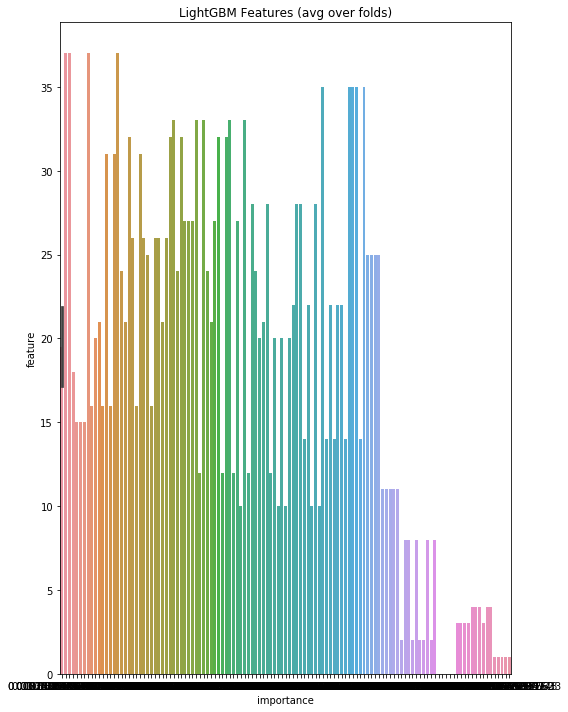

In [8]:
ml.run(scenario)

In [14]:
df = pd.read_pickle("./structure_df_01.pkl")
df["pred"] = ml.predicts.round().astype(int)
df.to_csv("./lightgbm.csv", index=False)

In [18]:
ml.engine.train[ml.engine.train["k_class"] != ml.engine.train["pred"]].shape

(113, 40)

In [20]:
1.0 - (113.0/837.0)

0.8649940262843488

In [ ]:
actual = pd.read_csv("../input/vortex/vortex_actual_05.csv")
actual["pred"] = ml.predicts
actual.to_csv("actual_05.csv")

In [ ]:
with open("selected.pkl", "rb") as f:
    hoge = pickle.load(f)

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
df = pd.concat([train, test])

In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
scaler = StandardScaler()
scaler.fit(train[["Age", "Fare"]])

train[["Age", "Fare"]] = scaler.transform(train[["Age", "Fare"]])
train["Age"].fillna(-9999, inplace=True)
train["Fare"].fillna(-9999, inplace=True)

In [ ]:
import umap

um = umap.UMAP()
um.fit(train[["Age", "Fare"]])

d = um.transform(train[["Age", "Fare"]])

In [ ]:
d[:, 1]

In [ ]:
train.head()

In [ ]:
train[["Age", "Fare"]] = train[["Age", "Fare"]].replace(np.inf, np.nan)

In [ ]:
df = pd.concat([ml.engine.train, ml.engine.test], ignore_index=True)
skip_columns = ["Survived"]

In [ ]:
feats = [f for f in df.columns if f not in skip_columns]
num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]

In [ ]:
num_columns

In [ ]:
for col in num_columns:
    df[col] = df[col].replace(np.inf, np.nan)
    df[col].fillna(-9999, inplace=True)

In [ ]:
um = umap.UMAP()
um.fit(df[num_columns])
df[num_columns] = um.transform(df[num_columns])

In [ ]:
df[num_columns].shape

In [ ]:
um.transform(df[num_columns])

In [ ]:
base_path = "./"
base_score = 0.7681353456669913

In [ ]:
best_score = 0.0
selected = set([])
params = None
scenario = None
with open(f"{base_path}/param_{base_score}.json") as f:
    params = json.load(f)
with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")

train_x = [f for f in train.columns if f not in ["Survived"]]

In [ ]:
scores = []
for col in train_x:
    if col not in selected:
        feats = list(selected) + [col]
        param_with_score = 1
        scores.append((col, param_with_score))

In [ ]:
b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1])[0]
if b_score > best_score:
    selected.add(b_feature)
    best_score = b_score
    print(f'selected:{b_feature}')
    print(f'score:{b_score}')
else:
    break